# MRN Normalization

1.  Loading data into a gene expression matrix.
2.  Munging data
3.  MRN Normalization
4.  Quick shot at maching learning.

"Trimmed Mean of M-values" (TMM) normalization, published by [Robinson and Oshlack](https://www.frontiersin.org/articles/10.3389/fgene.2016.00164/full#B16) is a widely used method of normalizing gene expression in scRNA data.  A variant called MRN (Median Ratio Normalization) is described by [Maza et al.](https://www.tandfonline.com/doi/full/10.4161/cib.25849), and may perform slightly better than TMM.  We carry out MRN normalization on the P9855 RNA data, and use the results in a quick machine learning application.

In [1]:
#Import packages.  Put plots "inline" in the notebook.  

import numpy as np  # For numerical computations.
import pandas as pd  # Pandas for data analysis.
import matplotlib.pyplot as plt  # For basic plotting.
import seaborn as sns # For pretty visualization in Seaborn.  See https://seaborn.pydata.org/

import os # Working with file directories, etc.

from IPython.display import display # Pretty display of data frames.

# Put plots inline rather than in a pop-up.
%matplotlib inline

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning) #got annoyed of these red boxes

Go to section 2, if you have already loaded the data and have the pickles.

# 1.  Loading the data

Start at section 2, if the raw data has already been processed and pickled.

In this section, we load the gene expression data and some metadata.  The sequencing data is stored in a 'merged_gene_counts.txt'.  The metadata is stored in a separate file called 'meta_data_marty_inVitro_feb8.csv'.  We use the metadata to select bulk-cells from  experiment P9855.  The first function loads the metadata.

In [ ]:
def get_meta(experiment, filename = 'meta_data_marty_inVitro_feb8.csv', report=True, bulks = False):
    df = pd.read_csv(filename, sep=',',
                     index_col=2, header=0, low_memory=False)
    df = df[ df['Project_ID'] == experiment] # Only cells from the experiment.
    if bulks:
        df = df[ df['Number_Of_Cells'] >= 25] # Include only bulks.
    else:
        df = df[ df['Number_Of_Cells'] == 1] # Get rid of bulks.
    if report:
        if bulks:
            print('{} bulks found in experiment {}'.format(len(df), experiment))
        else:
            print('{} single cells found in experiment {}'.format(len(df), experiment))
        clones = df['Clone_ID'].unique()
        print('{} Clones: {}'.format(len(clones), ', '.join(clones)))
        print('The first five rows of the dataframe are below')
        display(df[:5])
    return df

In [ ]:
meta_df = get_meta('P9855', filename = 'meta_data_marty_inVitro_feb8.csv')

In [ ]:
meta_bulks = get_meta('P9855', filename = 'meta_data_marty_inVitro_feb8.csv', bulks=True)

In [ ]:
meta_bulks.drop(meta_bulks.index[[range(69,99)]], inplace=True) # drop atac data... and c12 while we are cutting
                                                                # the tail off of the dataframe 
meta_bulks.drop(['In_Vivo_Clone_ID'],axis=1, inplace=True)
meta_bulks['Clone_ID'] = meta_bulks['Clone_ID'].str[-3:] # cleaning up clone id names
meta_bulks.sort_index().head()

In [ ]:
meta_bulks.shape

In [ ]:
meta_bulks['Clone_ID'].unique()

The sequencing data (in merged_gene_counts.txt) contains a separate row for each  gene.  The name of each column contains list of filenames (I'm guessing input for star), we will clean up column names.
But first, to take out bulks that are negatives or otherwise messed up... I'm doing this the brute way by excluding by a list. *If I were clever I would look at rows as triplets and make sure all three have 25 cells.*

In [ ]:
exclude_samples = ['P9855_2016', 'P9855_2017', 'P9855_2018', 'P9855_2043', 'P9855_2044', 'P9855_2045', 'P9855_2046', 'P9855_2047', 'P9855_2048', 'P9855_2055', 'P9855_2056', 'P9855_2057', 'P9855_2082', 'P9855_2083', 'P9855_2084']

In [ ]:
read_merged_genes = pd.read_csv('merged_gene_counts.txt', sep='\t', index_col=0)
read_merged_genes.columns = read_merged_genes.columns.str[:10] # 10 characters in P9855_20**
read_merged_genes.drop(['gene_name'],axis=1, inplace=True)
read_merged_genes = read_merged_genes.transpose() # tanspose dataframe for later analysis infrastructure
read_merged_genes.drop(list(read_merged_genes.index & exclude_samples), inplace=True)
read_merged_genes.sort_index().head()

In [ ]:
read_merged_genes.shape # great, the sizes for the meta and the rawreads have equal index sizes

In [ ]:
read_merged_genes.to_pickle('P9855_rawreads.pkl') # Save file as a pickle.
meta_bulks.to_pickle('P9855_meta.pkl') # Pickle the metadata too.

The next function loads an entire *list* of cells, and places their gene expression data into the rows of a matrix.  The rows are indexed by the cell names, and the columns by genes.  The data is the gene expression, as raw number of reads.  This may take a little while, so we give progress updates every 10 cells.

# 2.  Munging data

Start here if you have the pickles!  We filter the data a bit, before normalization downstream.

In [2]:
bulks_raw = pd.read_pickle('P9855_rawreads.pkl') # Load bulks expression matrix from a pickle.
meta_df = pd.read_pickle('P9855_meta.pkl') # Load metadata from a pickle.

In [3]:
genes = list(bulks_raw.columns)  # The names of the genes. 
bulks = list(bulks_raw.index) # The names of the bulks.
clones = sorted(list(meta_df.Clone_ID.unique())) # The names of the clones.

## Removing TCRs and rarely-expressed genes

T cells have special genetically rearranged receptors called TCRs.  These are made of segments called TRBV9, TRBJ2-4, TRAV12-2, TRAJ14, etc.  Bascally any gene that is called these letters followed by a number -- TRBV, TRBJ, TRAV, TRAJ -- is part of this receptor and they are defined as being clonal.  Therefore we exclude these genes since we want to find more interesting similarities within clonal populations.

The following loads a list of genes to be excluded from the data for later analysis.  The excluded genes should be given in a csv file with *one* column.  No row labels should be given.  The first row should be a descriptive header, like "Genes to exclude."

In [4]:
exc_filename = 'TRgenes.csv'  # CHANGE this if needed.  I added TRAC and TRDV3 as requested.
exc_df = pd.read_csv(exc_filename, sep=',', header=0)
exclude_genes = exc_df.iloc[:,0].tolist()

Next, we switch the labels from the hgnc name to the ensemble ID because there were two instances with the same hgnc name, however, they have unique ensemble IDs.

In [5]:
ensembl_hgnc_meta_filename = 'All_Gene_Info_Metadata.csv'
ensembl_hgnc_meta_df = pd.read_csv(ensembl_hgnc_meta_filename, sep=',', header=0)
ensembl_genes = pd.Series(ensembl_hgnc_meta_df.ensembl_gene_id.values,index=ensembl_hgnc_meta_df.hgnc_symbol).to_dict()
exclude_ensembl = [ensemblID for hgnc,ensemblID in ensembl_genes.items() if hgnc in exclude_genes]

In [6]:
def get_relevant(gf, eg, prevalence=0.05, threshold = 10): # gf = expression matrix, eg = list of genes to exclude
    '''
    Outputs True if the gene is relevant for analysis.  We throw out excluded genes.
    By default, we take genes that are found in at least 5% of all cells at a level of
    10 counts or more.
    '''
    nonzero_count = (gf > threshold).sum(axis=0)
    nonzero_proportion = nonzero_count / len(gf)
    return [gene for gene in gf.columns if
           (gene not in eg) & 
           (nonzero_proportion[gene] > prevalence)]

In [7]:

genes_relevant = get_relevant(bulks_raw, exclude_ensembl)


In [8]:
print("{} bulks are measured, from {} to {}.".format(len(bulks), bulks[0], bulks[-1]))
print("{} genes are measured, from {} to {}.".format(len(genes),genes[0],genes[-1]))
genes_excluded = [gene for gene in exclude_ensembl if gene in genes]
print("{} TCR genes were excluded, from {} to {}.".format(len(genes_excluded), genes_excluded[0], genes_excluded[-1]))
print("{} genes are considered relevant, from {} to {}.".format(len(genes_relevant), genes_relevant[0], genes_relevant[-1]))

69 bulks are measured, from P9855_2019 to P9855_2031.
63677 genes are measured, from ENSG00000223972 to ENSG00000235857.
187 TCR genes were excluded, from ENSG00000227191 to ENSG00000229164.
10195 genes are considered relevant, from ENSG00000225630 to ENSG00000251705.


We produce "violin-plots" giving the number of genes expressed by each cell, sorted by clonality.

In [9]:
def nGene(ge, md, cutoff = 10, plot=True): # ge = gene expression, md = meta data
    nG = ge.apply(lambda row: sum(row > cutoff), axis=1) # Number of genes expressed.
    nG.name = 'num_genes'
    clonalities = md.Clone_ID
    nGene_df = pd.concat([nG, clonalities], axis=1)
    if plot:
        fig,ax = plt.subplots(figsize=(12,8))
        sns.violinplot(x="Clone_ID", y="num_genes", inner='quartiles', data=nGene_df, ax=ax)
        sns.swarmplot(x="Clone_ID", y="num_genes", color="white", size=3, data=nGene_df, ax=ax);
    return nGene_df

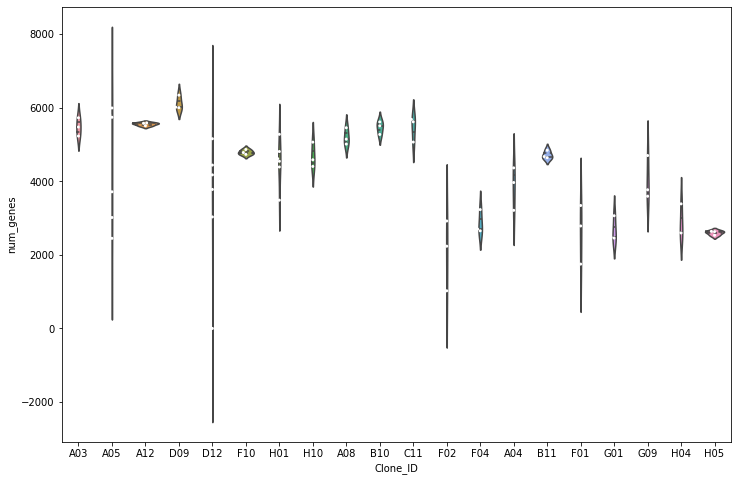

In [10]:
nG = nGene(bulks_raw, meta_df)

#  3.  MRN Normalization.

Here we implement MRN Normalization on the gene expression data, closely following the convenient outline in Section 3.2 of [Maza](https://www.frontiersin.org/articles/10.3389/fgene.2016.00164/full).  We begin by putting our filtered data into a dataframe.  The dataframe `EM` (for "expression matrix") contains the gene expressions for the cells, filtered as above.

In [11]:
EM = bulks_raw[genes_relevant]

In [12]:
EM.sort_index().head()

Geneid,ENSG00000225630,ENSG00000237973,ENSG00000248527,ENSG00000237491,ENSG00000228794,ENSG00000188976,ENSG00000187961,ENSG00000187608,ENSG00000217801,ENSG00000186891,...,ENSG00000185010,ENSG00000165775,ENSG00000185515,ENSG00000155959,ENSG00000155961,ENSG00000185973,ENSG00000124333,ENSG00000124334,ENSG00000225840,ENSG00000251705
P9855_2001,37,16,407,0,0,72,98,1044,0,1,...,0,153,211,41,0,0,0,0,1687,0
P9855_2002,67,29,555,0,0,0,0,2696,0,315,...,0,3,87,117,0,0,0,0,843,1
P9855_2003,39,16,255,0,0,119,0,2727,0,86,...,0,204,0,58,0,0,0,0,868,17
P9855_2004,29,12,298,0,0,19,0,431,0,106,...,0,134,153,94,0,0,0,0,1301,0
P9855_2005,38,19,260,0,0,146,0,419,0,166,...,0,160,96,768,0,50,117,0,871,4


## Step I:  Prenormalization by library size.

In Maza's article, $X_{gkr}$ stands for the raw count (number of reads) of gene $g$, for a cell number $r$ among clone $k$.  This information is contained in our expression matrix `EM`.  The first step is to normalize by library size, dividing $X_{gkr}$ by the total number of reads $N_{kr}$ of cell with numbers $k$, $r$.  

We find the total number of reads for each cell by simply summing the numbers in each row of the data frame `EM`.  We don't need to worry about the separate indices $k$ and $r$ yet.  We examine the resulting "library size" below.

In [13]:
library_size = EM.sum(axis=1) # Drop the clone column.  Sum along rows.
print(library_size.head())
library_size.describe()

P9855_2019    1490231
P9855_2054    1550287
P9855_2072    1493905
P9855_2025    1540660
P9855_2076    1376602
dtype: int64


count    6.900000e+01
mean     1.639008e+06
std      4.053302e+05
min      2.760000e+02
25%      1.492801e+06
50%      1.664191e+06
75%      1.853876e+06
max      2.393534e+06
dtype: float64

The library size is about 1.6 million +/- 40,000.  Now we normalize the expression matrix by dividing every cell's raw counts by the cell's library size.  Note that `EM` is a dataframe whose rows are indexed by the cells.  `library_size` is a series (basically an array) whose rows are indexed by cells.  Numpy/pandas will divide one array by another, term by term, if they have the same size.  So it can divide *each column* of `EM` by `library size`, in a quickly-broadcasted division.  To perform this on every column, we use the `apply` method with a "lambda" function... it's the quickest method I know.

In [14]:
Y = EM.apply(lambda column : column / library_size)
Y.sort_index() #does not update the Y expression matrix, just for the sake of  us looking at nicely sorted rows

Geneid,ENSG00000225630,ENSG00000237973,ENSG00000248527,ENSG00000237491,ENSG00000228794,ENSG00000188976,ENSG00000187961,ENSG00000187608,ENSG00000217801,ENSG00000186891,...,ENSG00000185010,ENSG00000165775,ENSG00000185515,ENSG00000155959,ENSG00000155961,ENSG00000185973,ENSG00000124333,ENSG00000124334,ENSG00000225840,ENSG00000251705
P9855_2001,0.000022,9.528562e-06,0.000242,0.000000,0.000000,4.287853e-05,5.836245e-05,6.217387e-04,0.000000,5.955352e-07,...,0.000000e+00,0.000091,1.256579e-04,2.441694e-05,0.000000e+00,0.000000,0.000000e+00,0.000000,0.001005,0.000000e+00
P9855_2002,0.000032,1.406487e-05,0.000269,0.000000,0.000000,0.000000e+00,0.000000e+00,1.307548e-03,0.000000,1.527736e-04,...,0.000000e+00,0.000001,4.219460e-05,5.674447e-05,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000409,4.849955e-07
P9855_2003,0.000022,8.912686e-06,0.000142,0.000000,0.000000,6.628810e-05,0.000000e+00,1.519056e-03,0.000000,4.790569e-05,...,0.000000e+00,0.000114,0.000000e+00,3.230849e-05,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000484,9.469729e-06
P9855_2004,0.000016,6.472925e-06,0.000161,0.000000,0.000000,1.024880e-05,0.000000e+00,2.324859e-04,0.000000,5.717750e-05,...,0.000000e+00,0.000072,8.252979e-05,5.070458e-05,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000702,0.000000e+00
P9855_2005,0.000018,8.762528e-06,0.000120,0.000000,0.000000,6.733311e-05,0.000000e+00,1.932368e-04,0.000000,7.655682e-05,...,0.000000e+00,0.000074,4.427383e-05,3.541906e-04,0.000000e+00,0.000023,5.395873e-05,0.000000,0.000402,1.844743e-06
P9855_2006,0.000011,1.759419e-06,0.000155,0.000000,0.000000,4.281254e-05,5.864731e-07,5.207881e-04,0.000000,1.196405e-04,...,0.000000e+00,0.000164,9.090333e-05,9.383570e-05,0.000000e+00,0.000000,7.682798e-05,0.000000,0.000449,1.172946e-06
P9855_2007,0.000009,8.515051e-06,0.000133,0.000009,0.000000,0.000000e+00,0.000000e+00,5.109030e-04,0.000000,1.684088e-04,...,0.000000e+00,0.000122,4.872501e-05,2.748469e-04,0.000000e+00,0.000048,7.379711e-05,0.000000,0.000367,0.000000e+00
P9855_2008,0.000036,1.359556e-05,0.000131,0.000000,0.000000,9.694224e-05,0.000000e+00,3.558490e-04,0.000000,1.400934e-04,...,0.000000e+00,0.000100,2.258045e-04,8.157335e-05,0.000000e+00,0.000051,0.000000e+00,0.000000,0.000403,0.000000e+00
P9855_2009,0.000024,4.451043e-06,0.000227,0.000000,0.000020,3.306489e-05,0.000000e+00,8.075464e-04,0.000000,1.367106e-04,...,2.543453e-06,0.000214,0.000000e+00,7.439601e-05,4.260284e-05,0.000032,1.157271e-04,0.000000,0.000369,0.000000e+00
P9855_2010,0.000010,6.594981e-06,0.000204,0.000011,0.000000,1.738677e-05,0.000000e+00,1.618768e-04,0.000008,7.674160e-05,...,0.000000e+00,0.000141,8.813293e-05,1.247051e-04,1.199087e-06,0.000009,4.796350e-06,0.000000,0.000335,0.000000e+00


Now `Y` is the dataframe with counts normalized by library size, and we pass to the next step.

## Step II:  Creation of reference sample.

A difference between TMM (used in edgeR), RLE (used in DeSeq2), and MRN, is how they create a reference sample.  In MRN, a reference sample is created by averaging the previous dataframe `Y` over cells within a single condition (clone).  We carry this out here.

Note the method-chaining in defining `Y_clonal` below.  The `assign` method tacks on a new column to `Y` for the clone_IDs.  The `groupby` method then groups cells by clonotypes.  The `apply` method then takes the means within each clonotype.  The end result is to replace the (prenormalized) gene expression for *each cell* by the averages for each clonotype.  

In [15]:
Y_clonal = Y.assign(Clone=meta_df['Clone_ID']).groupby('Clone').apply(np.mean) # Takes a few seconds.
display(Y_clonal)

Geneid,ENSG00000225630,ENSG00000237973,ENSG00000248527,ENSG00000237491,ENSG00000228794,ENSG00000188976,ENSG00000187961,ENSG00000187608,ENSG00000217801,ENSG00000186891,...,ENSG00000185010,ENSG00000165775,ENSG00000185515,ENSG00000155959,ENSG00000155961,ENSG00000185973,ENSG00000124333,ENSG00000124334,ENSG00000225840,ENSG00000251705
Clone,,,,,,,,,,,,,,,,,,,,,
A03,0.000025,1.083537e-05,0.000218,0.000000e+00,0.000000,0.000036,1.945415e-05,0.001149,0.000000,6.709160e-05,...,0.000000e+00,0.000069,0.000056,0.000038,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000632,3.318241e-06
A04,0.000026,4.809797e-06,0.000180,3.908558e-06,0.000000,0.000041,0.000000e+00,0.000203,0.000000,1.316694e-04,...,0.000000e+00,0.000154,0.000000,0.000055,0.000000e+00,5.653514e-05,0.000000e+00,0.000000e+00,0.000394,5.490462e-06
A05,0.000024,6.287673e-06,0.000161,0.000000e+00,0.000000,0.000034,9.774552e-08,0.000470,0.000000,4.774144e-05,...,0.000000e+00,0.000065,0.000036,0.000160,0.000000e+00,2.221119e-05,6.193878e-05,0.000000e+00,0.000456,8.979584e-07
A08,0.000021,7.102904e-06,0.000224,0.000000e+00,0.000000,0.000000,0.000000e+00,0.001133,0.000000,1.931611e-04,...,1.710872e-05,0.000115,0.000053,0.000087,0.000000e+00,2.832598e-05,0.000000e+00,0.000000e+00,0.000271,1.908727e-06
A12,0.000023,8.853884e-06,0.000164,2.996036e-06,0.000007,0.000043,0.000000e+00,0.000558,0.000000,1.484043e-04,...,8.478178e-07,0.000145,0.000092,0.000144,1.420095e-05,4.383885e-05,6.317474e-05,0.000000e+00,0.000380,0.000000e+00
B10,0.000022,1.303552e-05,0.000199,0.000000e+00,0.000006,0.000034,0.000000e+00,0.000740,0.000006,2.280812e-04,...,0.000000e+00,0.000052,0.000000,0.000044,1.042284e-05,5.299175e-05,3.640958e-05,0.000000e+00,0.000440,4.862991e-06
B11,0.000028,1.239801e-05,0.000205,7.955516e-06,0.000000,0.000032,0.000000e+00,0.000197,0.000000,2.308737e-05,...,0.000000e+00,0.000095,0.000041,0.000107,0.000000e+00,6.530321e-05,3.829707e-05,0.000000e+00,0.000866,0.000000e+00
C11,0.000015,1.096273e-05,0.000229,0.000000e+00,0.000000,0.000036,3.770229e-06,0.000124,0.000000,6.777483e-05,...,0.000000e+00,0.000037,0.000045,0.000065,1.563663e-05,1.170361e-05,6.294096e-05,1.597138e-05,0.000295,7.528745e-07
D09,0.000013,5.603293e-06,0.000213,3.797110e-06,0.000010,0.000012,0.000000e+00,0.000154,0.000023,6.398364e-05,...,3.734549e-06,0.000100,0.000046,0.000099,6.070605e-06,1.095393e-05,3.239176e-05,0.000000e+00,0.000363,2.172877e-06


Let's take our reference sample to be the A3 clonal average.

In [16]:
Y_ref = Y_clonal.loc['A03'] # Our reference sample.  Basically an average of all cells of clonotype A3.
Y_ref.describe()

count    10195.000000
mean         0.000098
std          0.000951
min          0.000000
25%          0.000002
50%          0.000021
75%          0.000067
max          0.076017
Name: A03, dtype: float64

## Step III:  Computation of size relative to reference sample.

Now we compute relative scaling factors for each clone, based on the median fold-changes between gene expression within that clone and the reference clone (A7, we have chosen above).  Due to dropouts (values of 0 in gene expression), we discard genes with zeros when computing fold changes.  This avoids division-by-zero problems, and it matches the implementation of [Maza et al.](https://www.tandfonline.com/doi/full/10.4161/cib.25849).  (See the R code in the supplementary information).  

In [17]:
tau = pd.Series(index = clones)
for clone in clones: # Why not a little loop.
    numerator = Y_clonal.loc[clone]
    denominator = Y_ref
    ok_genes = [gene for gene in genes_relevant if (numerator[gene] != 0) and (denominator[gene] != 0)]
    ratios = numerator[ok_genes] / denominator[ok_genes] # The ratios.
    tau[clone] = np.median(ratios)
print(tau)

A03    1.000000
A04    1.027786
A05    0.927503
A08    0.982095
A12    1.012397
B10    1.013930
B11    1.083771
C11    0.974028
D09    0.917053
D12    0.787892
F01    1.107920
F02    1.100040
F04    0.905154
F10    1.025108
G01    1.091459
G09    1.029758
H01    0.963068
H04    0.998730
H05    1.024810
H10    1.000675
dtype: float64


## Step IV:  Adjustment of relative scaling factors.

This step does not occur in MRN normalization.  Yay!

## Step V:  Effective library size.

In [18]:
# intermediate series to match the clone IDs with the samples
clonalities = pd.Series(meta_df['Clone_ID'], index=library_size.index)
clonalities.head()

P9855_2019    F10
P9855_2054    B11
P9855_2072    H01
P9855_2025    H10
P9855_2076    H05
Name: Clone_ID, dtype: object

In [19]:
#intermediate series to map tau scaling values to the samples
scalar_lib_size = clonalities.map(tau)
scalar_lib_size.head()

P9855_2019    1.025108
P9855_2054    1.083771
P9855_2072    0.963068
P9855_2025    1.000675
P9855_2076    1.024810
Name: Clone_ID, dtype: float64

In [20]:
#final series, for this step at least as the library_size values are scaled by tau values
effective_lib_size = scalar_lib_size * library_size
effective_lib_size.head()

P9855_2019    1.527648e+06
P9855_2054    1.680156e+06
P9855_2072    1.438732e+06
P9855_2025    1.541700e+06
P9855_2076    1.410755e+06
dtype: float64

## Step VI:  Computation of relative normalization/size factors.

In [21]:
geo_mean = np.exp(effective_lib_size.apply(np.log).mean()) # The geometric mean of the effective_lib_size series.
geo_mean # A single number!

1388322.264035869

In [22]:
effective_lib_size.mean() # Compare the geometric mean (above) to the usual mean here.  They shouldn't be *too* far.

1615739.9077813413

In [23]:
relative_normalization_factor = effective_lib_size / geo_mean
relative_normalization_factor.head()

P9855_2019    1.100356
P9855_2054    1.210206
P9855_2072    1.036310
P9855_2025    1.110477
P9855_2076    1.016158
dtype: float64

## Step VII:  Normalization of counts.

In [24]:
# here we normalize our raw counts by the relative normalization factor we just
# calculated in Step VI
mrn_counts = EM.div(relative_normalization_factor, axis=0)
mrn_counts.sort_index().head()

Geneid,ENSG00000225630,ENSG00000237973,ENSG00000248527,ENSG00000237491,ENSG00000228794,ENSG00000188976,ENSG00000187961,ENSG00000187608,ENSG00000217801,ENSG00000186891,...,ENSG00000185010,ENSG00000165775,ENSG00000185515,ENSG00000155959,ENSG00000155961,ENSG00000185973,ENSG00000124333,ENSG00000124334,ENSG00000225840,ENSG00000251705
P9855_2001,30.591404,13.228715,336.505448,0.0,0.0,59.529219,81.025882,863.173680,0.0,0.826795,...,0.0,126.499591,174.453684,33.898583,0.0,0.000000,0.000000,0.0,1394.802681,0.000000
P9855_2002,45.113109,19.526570,373.698142,0.0,0.0,0.000000,0.000000,1815.297641,0.0,212.098945,...,0.0,2.019990,58.579709,78.779608,0.0,0.000000,0.000000,0.0,567.617178,0.673330
P9855_2003,30.160845,12.373680,197.205526,0.0,0.0,92.029246,0.000000,2108.939097,0.0,66.508530,...,0.0,157.764421,0.000000,44.854590,0.0,0.000000,0.000000,0.0,671.272144,13.147035
P9855_2004,23.414892,9.688921,240.608200,0.0,0.0,15.340791,0.000000,347.993738,0.0,85.585467,...,0.0,108.192949,123.533740,75.896546,0.0,0.000000,0.000000,0.0,1050.440496,0.000000
P9855_2005,26.232173,13.116086,179.483286,0.0,0.0,100.786768,0.000000,289.244219,0.0,114.593175,...,0.0,110.451253,66.270752,530.166015,0.0,34.516017,80.767479,0.0,601.269009,2.761281


In [27]:
mrn_counts.shape

(69, 10195)

In [25]:
mrn_counts.to_pickle('P9855_mrn.pkl') # Pickle the metadata too.

In [26]:
mrn_counts.to_csv('P9855_mrn.csv') # Pickle the metadata too.

# 4.  Quick shot at machine learning

After preprocessing the data, one might want to quickly check how well gene expression can predict clonotype.  The following steps will test out a linear support vector classifier. 

In [ ]:
import statsmodels.api as sm

# Import various functions for stats.
from scipy.stats import f_oneway, binom, binom_test, kruskal, norm # For p-values, kruskal-wallis, Gaussian
from scipy.stats import kurtosis, skew # For detecting bimodality
from statsmodels.formula.api import ols

from bisect import bisect # See bisect.bisect.
from itertools import compress # I don't recall why this is here.

# Import from scikit, for machine learning.
# from sklearn import mixture  # Import Gaussian mixture

from sklearn.preprocessing import Binarizer, MinMaxScaler

from sklearn.model_selection import ShuffleSplit, train_test_split, GridSearchCV

from sklearn.feature_selection import SelectKBest, chi2, f_classif

from sklearn.metrics import accuracy_score

from sklearn.svm import LinearSVC # Linear Support Vector Classifier 
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
 
from sklearn.cluster import MiniBatchKMeans, KMeans
from sklearn.metrics.pairwise import pairwise_distances_argmin

from sklearn.manifold import TSNE


In [ ]:
X = mrn_counts
X_cells = mrn_counts.index
y = meta_df.loc[X_cells].Clone_ID

In [ ]:
SVMpipe = make_pipeline(MinMaxScaler(), 
                        SelectKBest(score_func = f_classif, k=100), 
                        LinearSVC(random_state=0, tol=1e-4, max_iter = 2000))

In [ ]:
# DANGER DANGER:  The following suppresses all warnings from Python.
# Otherwise, you'll probably get a bunch of convergence warnings...
# Alternatively, increase the number of iterations in the SVM.

import warnings
warnings.filterwarnings('ignore') # Ignore warnings.

param_grid = dict(linearsvc__C=[0.001, 0.01, 0.1, 1.0, 10, 100],
                  selectkbest__k = range(50,251,25),
                 )

grid_search = GridSearchCV(SVMpipe, param_grid=param_grid, cv=5, iid=False) #5-fold cross-validation.
grid_search.fit(X,y)

In [ ]:
def CV_map(gs, swap=False):  # parameter_grid and grid_search.
    '''
    A general-purpose visualization for grid-search cross-validations.
    Displays predictive accuracy as a heatmap, based on different
    choices of parameters.  Displays optimal parameters in title.
    
    Args:
        gs (sklearn.model_selection.GridSearchCV):  The grid-search object.
        swap:  Set to True to switch the axes.
        
    Returns:
        None
        
    '''
    results = gs.cv_results_
    means = results['mean_test_score']
    params = list(gs.param_grid.keys())
    
    ser = pd.Series(list(means),
                  index=pd.MultiIndex.from_tuples(
                      [tuple(d.values()) for d in results['params']])
               )
    gs_df = ser.unstack().fillna(0)
    gs_df.shape 
    if swap:
        gs_df = gs_df.transpose()
        params = params[::-1] # Switch the order of the parameter list.
    
    f, ax = plt.subplots(figsize=(12,12))
    sns.heatmap(gs_df, annot=True, square=True, fmt="2.0%", linewidths=.5, 
                cbar_kws={'fraction':0.025, 'pad':0.05}, ax=ax)
    cbar = ax.collections[0].colorbar
    cbar.set_ticks([.5, .6, .7, .8, .9])
    cbar.set_ticklabels(['50%', '60%', '70%', '80%', '90%'])
    ax.set_xlabel(params[1])
    ax.set_ylabel(params[0])
    plt.yticks(rotation=0)
    bestacc = gs.best_score_
    ax.set_title("Result of grid-search with 5-fold cross-validation. \n"
                 "Best score {0:2.1%} with parameters \n"
                 "{1} ".format(gs.best_score_, gs.best_params_))

In [ ]:
CV_map(grid_search)

In [ ]:
from sklearn import base

def confusion_matrix(X,y,pipe, reps=2, classlist = None):
    if classlist:
        classes = classlist
    else:
        classes = sorted(y.unique())
    counts = pd.DataFrame(0, index=classes, columns=classes)
    cpops = pd.DataFrame(0, index=classes, columns=['pop'])
    correct = 0
    total = 0
    for t in range(reps):
        this_pipe = base.clone(pipe)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
        this_pipe.fit(X_train, y_train)
        y_pred = this_pipe.predict(X_test)
        actual = y_test
        predicted = y_pred
        for j in range(len(y_test)):
            total += 1
            if y_test[j] == y_pred[j]:
                correct += 1
            cpops.loc[y_test[j],'pop'] += 1
            counts.loc[y_test[j], y_pred[j]] += 1
    
    valid = counts.apply(lambda column : column/cpops['pop']) #['pop'] )
    
    f, ax = plt.subplots(figsize=(len(classes)+1,len(classes)))
    sns.heatmap(valid, annot=valid, square=True, fmt="2.0%", linewidths=.5, 
                cbar_kws={'fraction':0.046, 'pad':0.04}, ax=ax)
    cbar = ax.collections[0].colorbar
    cbar.set_ticks([0, .25, .5, .75, 1])
    cbar.set_ticklabels(['0%', '25%', '50%', '75%', '100%'])
    ax.set_ylabel("Actual class")
    ax.set_xlabel("Predicted class")
    ax.set_title("Overall prediction accuracy {:0.3%}. \n"
                 "{} trials, in {} batches with independent splits.".format(correct/total, total, reps))

In [ ]:
opt_k = grid_search.best_params_['selectkbest__k'] # Use optimal number of genes.
opt_C = grid_search.best_params_['linearsvc__C'] # Use optimal C-parameter for linear SVM.

SVMpipe = make_pipeline(MinMaxScaler(), 
                        SelectKBest(score_func = f_classif, k=opt_k), 
                        LinearSVC(random_state=0, tol=1e-4, max_iter = 2000, C=opt_C))

confusion_matrix(X,y,SVMpipe, reps=50, classlist = clones)